# **REMOTE SENSING**
##### **Visión por computador (DATCOM 23/24)**
##### Domingo Jesús López Pacheco

---

Utiliza las imágenes Landsat para:


# 1. INUNDACIÓN EN TEXAS

**Calcular una estimación del área de la inundación de Texas (en km2). Para ello debes tener en cuenta que:**
- **Las distintas bandas pueden no estar correctamente alineadas. Debes alinearlas, aunque sea de forma manual.**
- **No consideres las franjas negras de las imágenes. Se deben a una avería en los sensores del satélite.**
- **Puedes usar los índices de humedad que tienes al final de este documento (NDWI, ...).**

</br>


En primer lugar, es importante revisar la documentación de LANDSAT. 
Lo que más nos interesa es saber cómo se organizan las bandas y qué información nos van a permitir manejar. 

- Bandas 1 - 3 : Son las bandas BGR
- Bandas 4,5 y 7: Son bandas Infrarrojas (4 - NearIR, 5 y 7: Mid IR)
- Banda 6: Banda Térmica. Se divide en dos. Útil para tareas de detección de temperatura, estudio del clima, etc. 
- Banda 8: Banda pancromática, más detallada para tareas que requieran detectar características más depuradas.

La combinación entre ellas nos puede servir para distintos propósitos, por ejemplo:
- La combinación de la 1 - 3 nos da un rgb tal y como se observaba la imagen en el mundo real. 
- La combinación de la 4,5 o 7 con las anteriores se usa en tareas para demostrar las condiciones de la vegetación.

In [1]:
# Importación de paquetes
import numpy as np
import cv2
from matplotlib import pyplot as plt
import copy 
from inpainting_Criminisi.inpainter import Inpainter
import sys as sys
import os as os
import warnings
import pywt
from collections import Counter
from copy import copy, deepcopy
# Ignoramos los warnings
warnings.filterwarnings("ignore")

In [2]:
# Cargamos Bandas

# Bandas Agosto 
# (61 y 62 están en 512 y se amplian a 1014 en 61s y 62s, nos quedamos con estas)
# banda8 en 2048x2048, se reduce en banda8s, nos quedamos con esta
agosto_banda1 = cv2.imread("LandSat/texas/agosto_banda1.tif",0)
agosto_banda2 = cv2.imread("LandSat/texas/agosto_banda2.tif",0)
agosto_banda3 = cv2.imread("LandSat/texas/agosto_banda3.tif",0)
agosto_banda4 = cv2.imread("LandSat/texas/agosto_banda4.tif",0)
agosto_banda5 = cv2.imread("LandSat/texas/agosto_banda5.tif",0)
agosto_banda6_1 = cv2.imread("LandSat/texas/agosto_banda61s.tif",0)
agosto_banda6_2 = cv2.imread("LandSat/texas/agosto_banda62s.tif",0)
agosto_banda7 = cv2.imread("LandSat/texas/agosto_banda7.tif",0)
agosto_banda8 = cv2.imread("LandSat/texas/agosto_banda8s.tif",0)


agosto_bandas = [agosto_banda1, agosto_banda2, agosto_banda3, agosto_banda4, agosto_banda5,
                 agosto_banda6_1, agosto_banda6_2, agosto_banda7, agosto_banda8]

# Bandas Septiembre 
# (61 y 62 están en 512 y se amplian a 1014 en 61s y 62s, nos quedamos con estas)
# banda8 en 2048x2048, se reduce en banda8s, nos quedamos con esta
septiembre_banda1 = cv2.imread("LandSat/texas/septiembre_banda1.tif",0)
septiembre_banda2 = cv2.imread("LandSat/texas/septiembre_banda2.tif",0)
septiembre_banda3 = cv2.imread("LandSat/texas/septiembre_banda3.tif",0)
septiembre_banda4 = cv2.imread("LandSat/texas/septiembre_banda4.tif",0)
septiembre_banda5 = cv2.imread("LandSat/texas/septiembre_banda5.tif",0)
septiembre_banda6_1 = cv2.imread("LandSat/texas/septiembre_banda61s.tif",0)
septiembre_banda6_2 = cv2.imread("LandSat/texas/septiembre_banda62s.tif",0)
septiembre_banda7 = cv2.imread("LandSat/texas/septiembre_banda7.tif",0)
septiembre_banda8 = cv2.imread("LandSat/texas/septiembre_banda8s.tif",0)


septiembre_bandas = [septiembre_banda1, septiembre_banda2, septiembre_banda3, septiembre_banda4, septiembre_banda5,
                 septiembre_banda6_1, septiembre_banda6_2, septiembre_banda7, septiembre_banda8]

# Veamos la dimensión de las imágenes (todas las seleccionadas tienen la misma dimensión):
septiembre_banda1.shape

(1024, 1024)

(<Axes: >, <matplotlib.image.AxesImage at 0x7fe481df1150>)

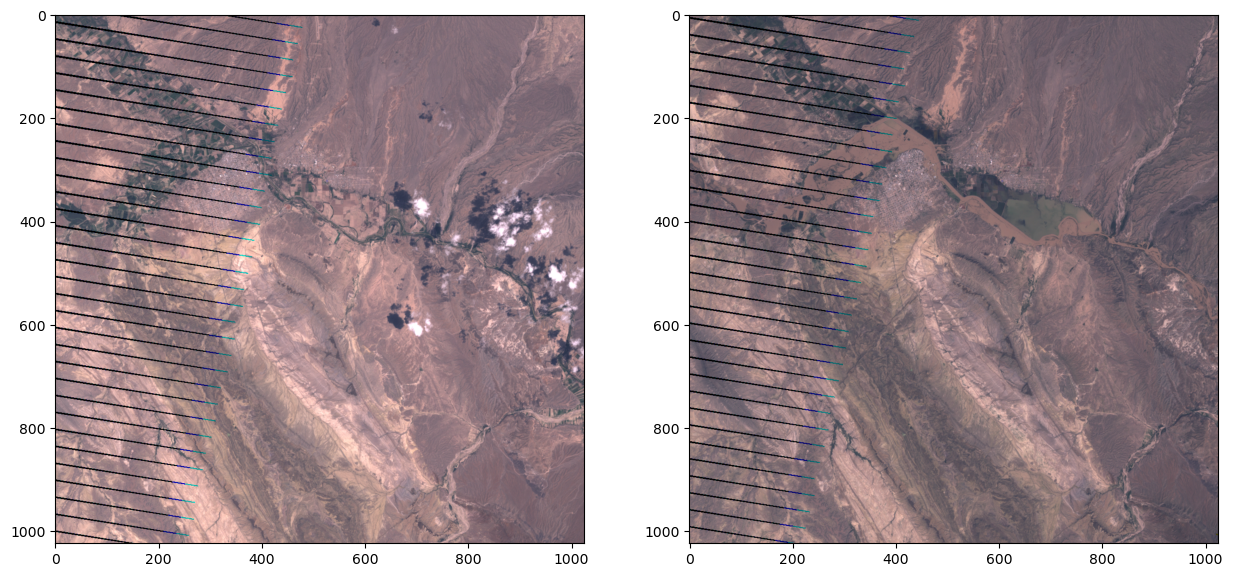

In [3]:
# Combinamos las bandas 1-3 Agosto y Septiembre, para ver RGB 

# Combinamos las tres bandas RGB de agosto
img_rgb_agosto = cv2.merge([agosto_banda1, agosto_banda2, agosto_banda3])
# Combinamos las tres bandas RGB de septiembre
img_rgb_septiembre = cv2.merge([septiembre_banda1, septiembre_banda2, septiembre_banda3])
# Mostramos
plt.figure(figsize=(15,8))
plt.subplot(121), plt.imshow(cv2.cvtColor(img_rgb_agosto, cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cv2.cvtColor(img_rgb_septiembre, cv2.COLOR_BGR2RGB))

Se observa claramente la inundación, pero hemos de realizar un preprocesado de las imágenes ante de poder calcular la superficie inundada. 
1. Alineación de las imágenes: Las bandas de Agosto y Septiembre no están alineadas. Deberían estarlo para poder realizar una estimación fiable. 
2. Eliminar las franjas negras que se observan debido a un fallo del sensor. 

### Ajuste de las bandas.

Vamos a reajustar las bandas de Agosto, para que estén colocadas como las de septiembre, que son las que contienen la inundación. 

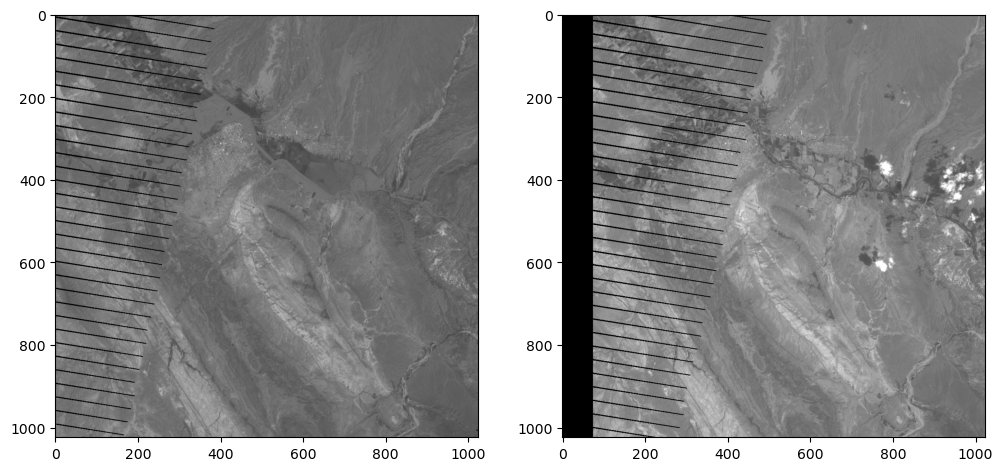

In [4]:
# Al final, ajuste manual. Los algoritmos de ajuste que había no me han convencido. 
# Una forma intermedia podria ser haber fijado cuatro puntos en ambas imágenes, Agosto y Septiembre y obtener la matriz de proyección.
#

'''
Función para hacer la transformación de forma manual
pasando un número de píxeles a mover
'''
def desplaza_pixeles(img, pixeles_desplazar):

    desplazamiento = pixeles_desplazar
    filas, columnas = img.shape
    matriz_desplazamiento = np.float32([[1, 0, -desplazamiento], [0, 1, 0]])
    imagen_desplazada = cv2.warpAffine(img, matriz_desplazamiento, (columnas, filas))

    return imagen_desplazada

# Alineamos (aproximación manual)
agosto_bandas_alineadas = []
for i in range(len(agosto_bandas)):
    agosto_bandas_alineadas.append(desplaza_pixeles(agosto_bandas[i], -75))

# Mostramos resultado de una de llas
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(cv2.cvtColor(septiembre_bandas[0],0))
plt.subplot(122)
plt.imshow(cv2.cvtColor(agosto_bandas_alineadas[0],0))

### Eliminación de líneas negras y proceso de reajuste.

Para poder eliminar las líneas negras fruto de error en la captación de la imagen por el sensor satelital, así como la zona negra producida por la alineación, vamos a aplicar umbralización, a fin de obtener una máscara con la que poder realizar "impainting" y reconstruir las imágenes. 
Este proceso lo vamos a realizar para cada una de las Bandas. 

In [5]:
'''
Funciones de Inpainting, obtenidas de prácticas anteriores de inpainting.
'''
def inpainting1(img, mask):

    # 1. Primer Algoritmo de opencv "An Image Inpainting Technique Based on the Fast Marching Method"
    rec= cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)

    return rec

def inpainting2(img, mask):

    # 2. Segundo Algoritmo de opencv "Navier-Stokes, Fluid Dynamics, and Image and Video Inpainting"
    rec= cv2.inpaint(img,mask,3,cv2.INPAINT_NS)

    return rec

def inpainting3(img, mask, patch_size = 9, verbose = False):

    stdout_orig = sys.stdout
    if(not verbose):
        # Evitamos que se imprima por pantalla la 
        # ejecución del algoritmo de parches de inpainting
        sys.stdout = open(os.devnull, 'w')

    # 3. Tercer Algoritmo. Parches. 
    # Este es el mejor, pero mucho más costoso computacionalmente. Utilizamos
    # mejor el primer algoritmo que para la tarea va de sobra.
    mask = mask/255
    rec = Inpainter(img,mask,
        patch_size=patch_size,
        plot_progress=0
    ).inpaint()

    sys.stdout = stdout_orig

    return rec


'''
Función para umbralizar y calcular la máscara de la líneas del error de cada banda
'''
def calcula_mascara(img, porcentaje_umbral):
    # Normalizamos
    norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    # Pasamos a entero
    norm_int = norm.astype('uint8')
    # fijamos umbral
    umbral = 255 * porcentaje_umbral
    # Binarizar la imagen resultante (255 para establecer los píxeles que superen dicho umbral a 255)
    _, resultado_umbral = cv2.threshold(norm_int, umbral, 255, cv2.THRESH_BINARY)


    return img, resultado_umbral


'''
Función para realizar el inpainting y reconstrucción de las líneas 
de error del satélite.
'''
def do_inpainting(img, mask,algo=1):

    # Obtenemos la máscara
    lower_black = np.array([0], dtype=np.uint8)
    upper_black = np.array([0], dtype=np.uint8)
    mask = cv2.inRange(mask, lower_black, upper_black)

    if(algo==1):
        rec = inpainting1(img, mask)
    elif(algo == 2):
        rec = inpainting2(img, mask)
    elif(algo == 3):
        rec = inpainting3(img, mask, patch_size=9)

    return img, rec

'''
Función para ver si una imagen ya existe en un directorio
'''
def check_img_exists(directorio, nombre_imagen):
    ruta_imagen = os.path.join(directorio, nombre_imagen)
    
    return True if os.path.exists(ruta_imagen) else False


'''
Función que calcula el número km² afectados
teniendo en cuenta la resolución del satélite
'''
def calcula_km_afectados(num_pixeles):
    # Cada pixel son 30 metros en las bandas que 
    # estamos analizando.
    pixel_km_2 = 0.030*0.030 #km*km
    km_2 = num_pixeles*pixel_km_2
    return km_2


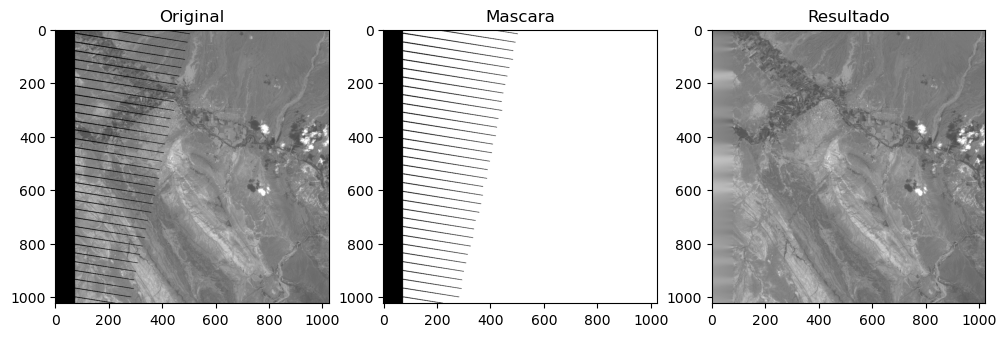

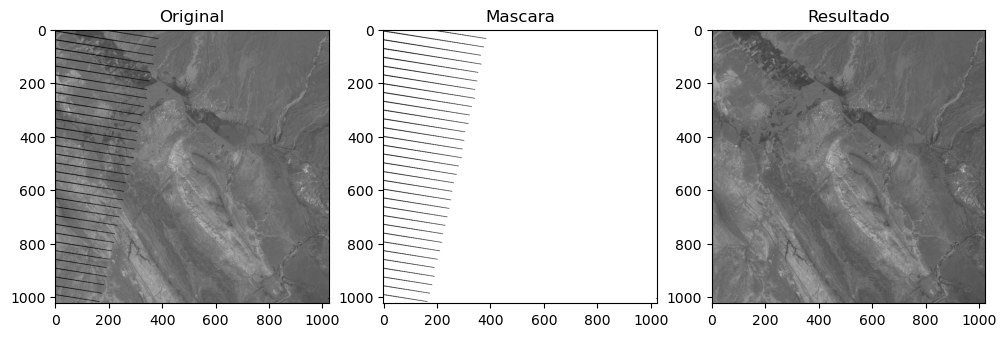

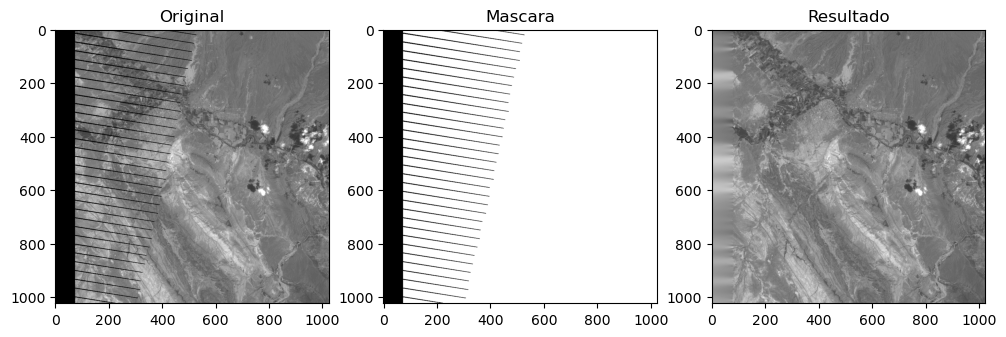

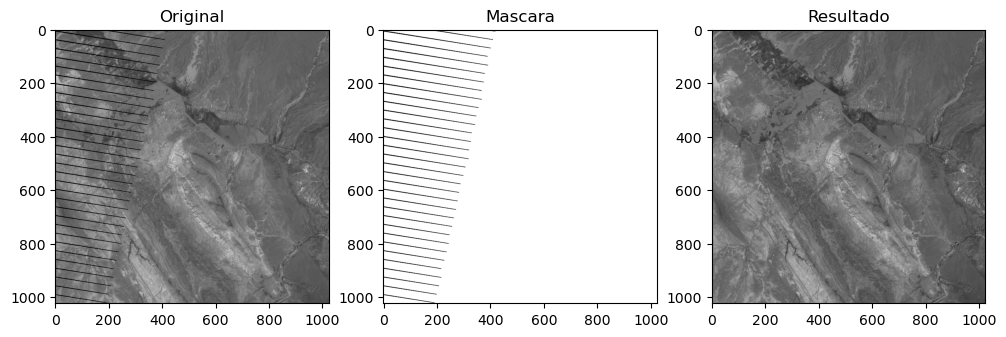

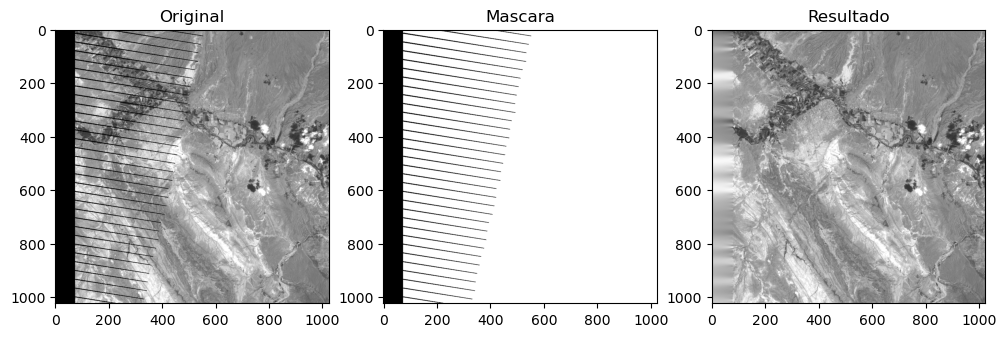

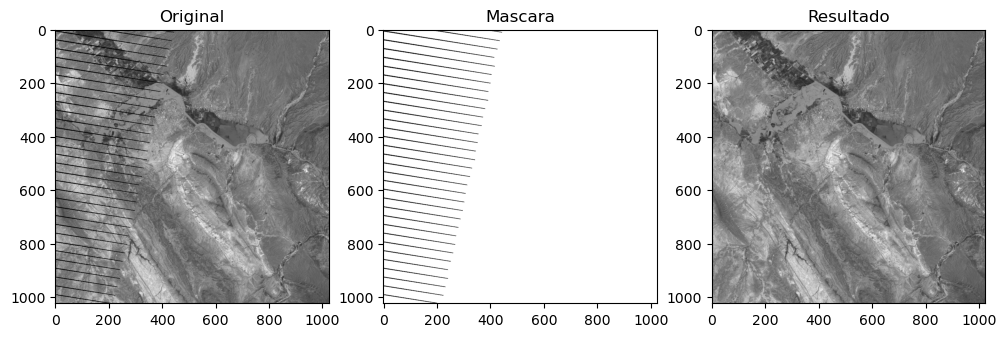

In [6]:
# Eliminación de bandas negras en las imágenes
agosto_procesadas = []
septiembre_procesadas = []
for i in range(len(agosto_bandas_alineadas)):

    if(i not in (5,6,8)):
        ratio = 0.01
    else:
        ratio = 0.2

    img, mask = calcula_mascara(agosto_bandas_alineadas[i], ratio)
    # Usamos el algoritmo de inpainting más básico. 
    # Se podría hacer con el mejor, que es el último, basado en
    # parches, pero es muy lento.
    img, rec = do_inpainting(img,mask,1)
    agosto_procesadas.append(rec)

    # Mostramos solo las 3 primeras
    if(i in (0,1,2)):
        plt.figure(figsize=(12,6))
        plt.subplot(131), plt.imshow(img,'gray'), plt.title("Original")
        plt.subplot(132), plt.imshow(mask,'gray'), plt.title("Mascara")
        plt.subplot(133), plt.imshow(rec,'gray'), plt.title("Resultado")

    img, mask = calcula_mascara(septiembre_bandas[i], ratio)
    img, rec = do_inpainting(img,mask,1)
    septiembre_procesadas.append(rec)

    # Mostramos solo las 3 primeras
    if(i in (0,1,2)):
        plt.figure(figsize=(12,6))
        plt.subplot(131), plt.imshow(img,'gray'), plt.title("Original")
        plt.subplot(132), plt.imshow(mask,'gray'), plt.title("Mascara")
        plt.subplot(133), plt.imshow(rec,'gray'), plt.title("Resultado")

(<Axes: >, <matplotlib.image.AxesImage at 0x7fe475145410>)

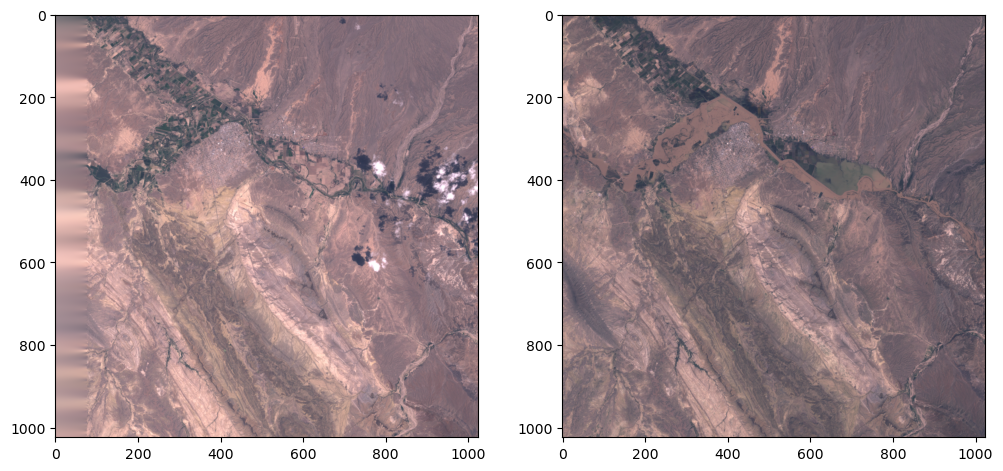

In [7]:
# Volvemos a combinar las bandas 1-3 Agosto y Septiembre, para ver RGB 
# Combinamos las tres bandas RGB de agosto
img_rgb_agosto = cv2.merge([agosto_procesadas[0], agosto_procesadas[1], agosto_procesadas[2]])
# Combinamos las tres bandas RGB de septiembre
img_rgb_septiembre = cv2.merge([septiembre_procesadas[0], septiembre_procesadas[1], septiembre_procesadas[2]])
# Mostramos
plt.figure(figsize=(12,8))
plt.subplot(121), plt.imshow(cv2.cvtColor(img_rgb_agosto, cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cv2.cvtColor(img_rgb_septiembre, cv2.COLOR_BGR2RGB))

### Cálculo de de la estimación del área de inundación en Texas (km²), usando índice NDWI

Para calcular la estimación del área de inundación, vamos a realizar diferentes pasos:
1. Cálculo del NDWI (Índice de Agua Normalizada). Nos dará una matriz de pesos donde veremos claramente diferenciadas las zonas de agua dado que tendrán mayor valor (o menos valor según las bandas y fórmula que apliquemos). 
2. Con esa matriz como imagen, podemos umbralizar y obtener todos los píxeles correspondientes al agua de la inundación. 
3. Dado que en la descripción de LandSAT tenemos cuánto mide cada pixel en la imagen obtenida por satélite (para LandSat 7, Sensor ETM+, Bandas 4 y 5 - 30 metros<sup>2</sup>), podemos calcular facilmente cuanta superficie tiene agua.

Con esto, lo tenemos todo listo para realizar el cálculo.


(<Axes: title={'center': 'NDWI Mask Septiembre'}>,
 Text(0.5, 1.0, 'NDWI Mask Septiembre'))

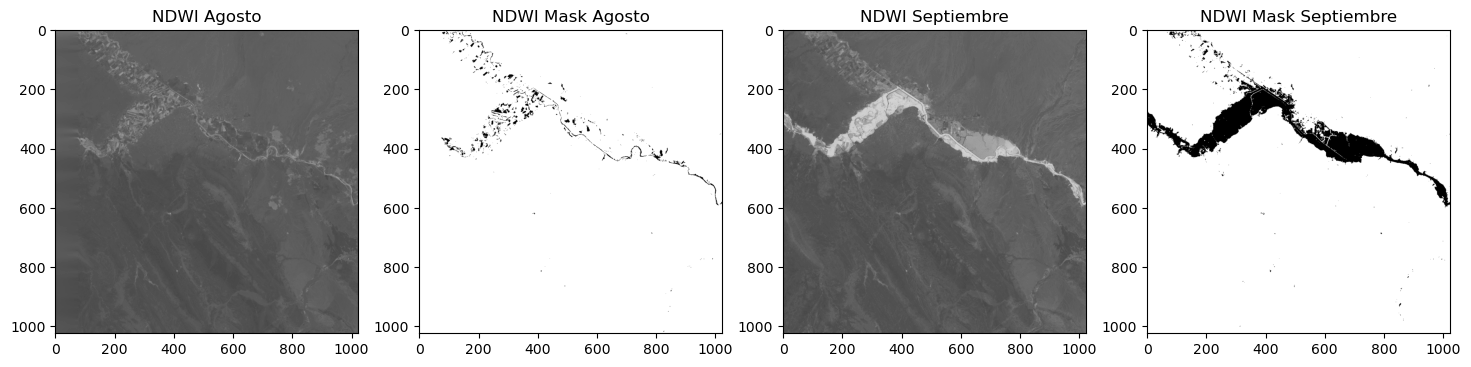

In [8]:
# 1. CALCULO DEL NDWI (Matriz de Pesos)

# Al combinar la banda de infrarojo (Near IR) con la banda Mid IR se ve claramente la inundación

# Este indicador es el que más me ha convencido. Aparece en el paper 
# "Classification using multi temporal MODIS data with Köppen Climate Chart "
# NSIDC Soil Moisture Experiment 2002 (SMEX02) project was defined NDWI as
# NDWI = B4 – B5 / B4 + B5 (Landsat TM/ETM+ B4:0.75-0.9 B5:1.55-1.75) 
# Este LandSat TM/ETM+ es el dispositivo del cual tenemos las imágenes,
# por eso viene que ni pintao este cálculo. En RGB.

# bandas 4 y 5, que son la NIR y MIR (Infrarrojas cercana y corta/media)

# ###################################################3
# AGOSTO EN TEXAS
# ###################################################3
banda_nir = agosto_procesadas[3]
banda_mir = agosto_procesadas[4]
# Calcuamos NDVI 
banda_nir = banda_nir.astype(np.float32)
banda_mir = banda_mir.astype(np.float32)
ndwi_agosto = (banda_nir - banda_mir) / (banda_nir + banda_mir)
# Tenemos valores infinitos y nans por la operación, regularizamos
ndwi_agosto = np.where(np.isinf(ndwi_agosto), 1, ndwi_agosto)
# También tenemos nans, los ponemos a un valor medio entre -1 y 1
ndwi_agosto = np.nan_to_num(ndwi_agosto, nan=0)
# Normalizamos entre 0 y 255
ndwi_agosto = cv2.normalize(ndwi_agosto, None, 0, 255,cv2.NORM_MINMAX)
# Pasamos a entero
ndwi_agosto = ndwi_agosto.astype('uint8')
# Calculamos máscara al 50%
img_agosto, mask_agosto = calcula_mascara(ndwi_agosto,0.50)
mask_agosto_ndwi = 255 - mask_agosto

# ###################################################3
# SEPTIEMBRE EN TEXAS
# ###################################################3
banda_nir = septiembre_procesadas[3]
banda_mir = septiembre_procesadas[4]
# Calcuamos NDVI 
banda_nir = banda_nir.astype(np.float32)
banda_mir = banda_mir.astype(np.float32)
ndwi_septiembre = (banda_nir - banda_mir) / (banda_nir + banda_mir)
# Tenemos valores infinitos y nans por la operación, regularizamos
ndwi_septiembre = np.where(np.isinf(ndwi_septiembre), 1, ndwi_septiembre)
# También tenemos nans, los ponemos a un valor medio entre -1 y 1
ndwi_septiembre = np.nan_to_num(ndwi_septiembre, nan=0)
# Normalizamos entre 0 y 255
ndwi_septiembre = cv2.normalize(ndwi_septiembre, None, 0, 255,cv2.NORM_MINMAX)
# Pasamos a entero
ndwi_septiembre = ndwi_septiembre.astype('uint8')
# Calculamos máscara al 50%
img_septiembre, mask_septiembre = calcula_mascara(ndwi_septiembre,0.50)
mask_septiembre_ndwi = 255 - mask_septiembre

# Mostramos
plt.figure(figsize=(18,6))
plt.subplot(141), plt.imshow(img_agosto,'grey'), plt.title("NDWI Agosto")
plt.subplot(142), plt.imshow(mask_agosto_ndwi,'grey'), plt.title("NDWI Mask Agosto")
plt.subplot(143), plt.imshow(img_septiembre,'grey'), plt.title("NDWI Septiembre")
plt.subplot(144), plt.imshow(mask_septiembre_ndwi,'grey'), plt.title("NDWI Mask Septiembre")


In [9]:
# 3. CÁLCULO DE KM^2 

# a. Contar número de píxeles negros (0) (Se ha hecho umbralización y normalización binaria en la función que calcula la máscara)
num_pixeles_ag = np.sum(mask_agosto_ndwi == 0)
num_pixeles_sep = np.sum(mask_septiembre_ndwi == 0)

km_ag = calcula_km_afectados(num_pixeles_ag)
km_sep = calcula_km_afectados(num_pixeles_sep)

print(f"Aproximación de Km^2 de superficie acuosa en Agosto: {round(km_ag,2)} km^2")
print(f"Aproximación de Km^2 de superficie acuosa en Septibembre: {round(km_sep,2)} km^2\n")
print(f"Aproximación de Km^2 de superficie acuosa anormales, fruto de inundación en Texas: {round(km_sep - km_ag,2)} km^2")

Aproximación de Km^2 de superficie acuosa en Agosto: 9.68 km^2
Aproximación de Km^2 de superficie acuosa en Septibembre: 55.33 km^2

Aproximación de Km^2 de superficie acuosa anormales, fruto de inundación en Texas: 45.65 km^2


# 2. INCENDIO ARIZONA

- **Si combinas las bandas 7, 5 y 4 (como R,G,B) puedes obtener una imagen en falso color que permite visualizar claramente la zona quemada y los focos del fuego.**
- **Calcula una estimación del área de la zona quemada (en km2). Esto puedes hacerlo de distintas formas:**
    - Usando algún índice de vegetación (NDVI, ...). Al final de este documento tienes más información.
    - Usando la imagen en falso color.
    - ...

- **Implementa el algoritmo del documento y verifica si es útil para detectar los focos del incendio. Compara los resultados con la imagen anterior (falso color).**


</br>


In [10]:
# Cargamos Bandas

# Bandas Agosto 
# (61 y 62 están en 512 y se amplian a 1014 en 61s y 62s, nos quedamos con estas)
# banda8 en 2048x2048, se reduce en banda8s, nos quedamos con esta
arizona_banda1 = cv2.imread("LandSat/arizona/banda1.tif",0)
arizona_banda2 = cv2.imread("LandSat/arizona/banda2.tif",0)
arizona_banda3 = cv2.imread("LandSat/arizona/banda3.tif",0)
arizona_banda4 = cv2.imread("LandSat/arizona/banda4.tif",0)
arizona_banda5 = cv2.imread("LandSat/arizona/banda5.tif",0)
arizona_banda6 = cv2.imread("LandSat/arizona/banda6.tif",0)
arizona_banda7 = cv2.imread("LandSat/arizona/banda7.tif",0)
arizona_rgb = cv2.imread("LandSat/arizona/rgb.jpg")

arizona_bandas = [arizona_banda1, arizona_banda2, arizona_banda3, arizona_banda4, arizona_banda5,
                 arizona_banda6, arizona_banda7]

# Veamos la dimensión de las imágenes (todas las seleccionadas tienen la misma dimensión):
arizona_banda1.shape

(1900, 1301)

#### **2.1. Combinación de bandas 7,5 y 5. Imagen en falso color.**

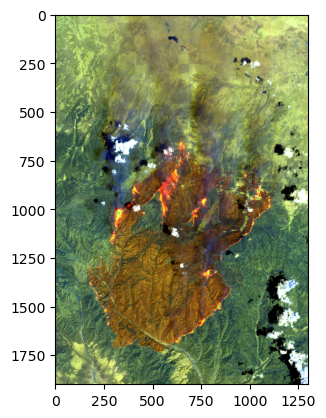

In [11]:
arizona_banda7_rgb = cv2.cvtColor(arizona_banda7,cv2.COLOR_BGR2RGB)
arizona_banda5_rgb = cv2.cvtColor(arizona_banda5,cv2.COLOR_BGR2RGB)
arizona_banda4_rgb = cv2.cvtColor(arizona_banda4,cv2.COLOR_BGR2RGB)

arizona_falso_color = cv2.merge([arizona_banda7_rgb[:,:,0],arizona_banda5_rgb[:,:,0],arizona_banda4_rgb[:,:,0]])
plt.imshow(arizona_falso_color)

##### **ALTERNATIVA 1: Usando algún índice de vegetación (NDVI)**
 


(<Axes: title={'center': 'NDVI Mask'}>,
 Text(0.5, 1.0, 'NDVI Mask'))

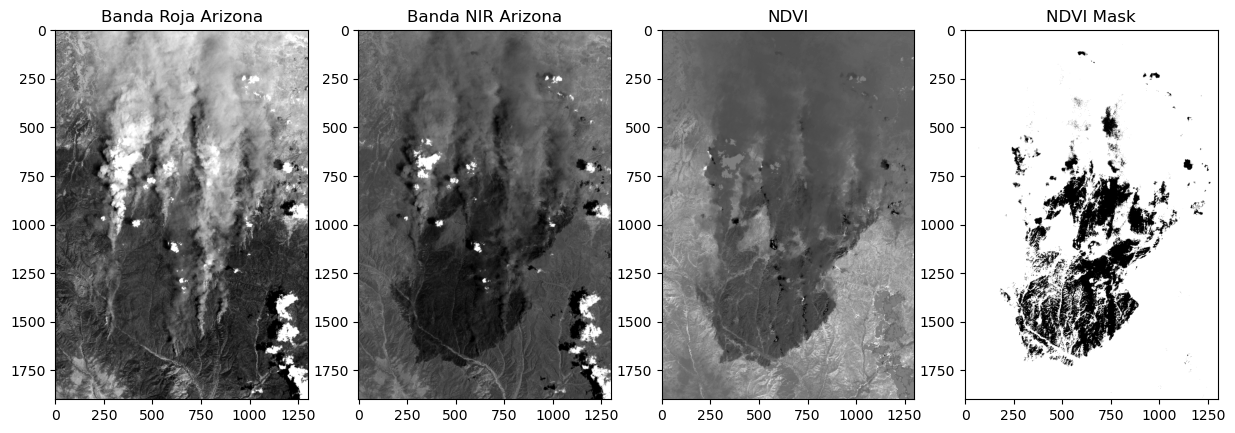

In [12]:
# Podemos aplicar la fórmula indicada en (https://es.wikipedia.org/wiki/%C3%8Dndice_de_vegetaci%C3%B3n_de_diferencia_normalizada):
# (NIR - ROJA)/(NIR + ROJA)

# bandas 3 y 4, que son la ROJA y NIR 
banda_roja = arizona_banda3
banda_nir = arizona_banda4

# Calcuamos NDVI 
banda_roja = banda_roja.astype(np.float32)
banda_nir = banda_nir.astype(np.float32)
ndvi = (banda_nir - banda_roja) / (banda_nir + banda_roja)
# También tenemos nans, los ponemos a un valor medio entre -1 y 1
ndvi = np.nan_to_num(ndvi, nan=0)
# Normalizamos entre 0 y 255
ndvi = cv2.normalize(ndvi, None, 0, 255,cv2.NORM_MINMAX)
# Pasamos a entero
ndvi = ndvi.astype('uint8')
# Calculamos máscara
img_arizona, mask_arizona = calcula_mascara(ndvi,0.30)

# Mostramos NDVI en BGR
plt.figure(figsize=(15,6))
plt.subplot(141), plt.imshow(banda_roja,'grey'), plt.title("Banda Roja Arizona")
plt.subplot(142), plt.imshow(banda_nir,'grey'), plt.title("Banda NIR Arizona")
plt.subplot(143), plt.imshow(ndvi,'grey'), plt.title("NDVI")
plt.subplot(144), plt.imshow(mask_arizona,'grey'), plt.title("NDVI Mask")



In [13]:
# Calculamos km afectados
num_pixeles_afectados = np.sum(mask_arizona == 0)
km = calcula_km_afectados(num_pixeles_afectados)

print(f"Aproximación de Km^2 de superficie afectada en incendio de Arizona: {round(km,2)} km^2")

Aproximación de Km^2 de superficie afectada en incendio de Arizona: 275.09 km^2


##### **ALTERNATIVA 2: Usando la imagen en falso color.**



(<Axes: title={'center': 'Máscara Arizona Zona afectada Inv.'}>,
 Text(0.5, 1.0, 'Máscara Arizona Zona afectada Inv.'))

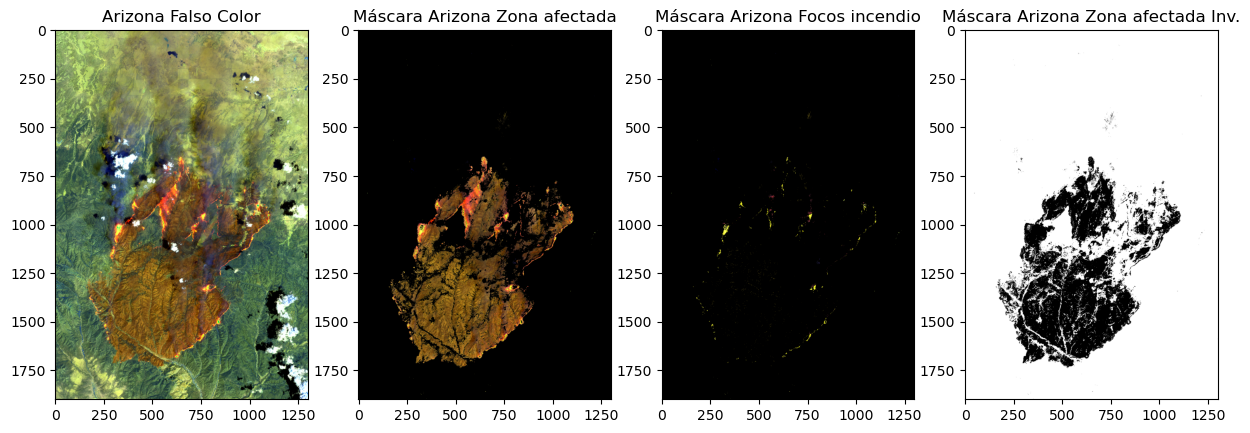

In [14]:
# Este proceso es muy similar al del ejercicio anterior 
# Pasamos esta vez a hsv, nos será más cómodo para trabajar
# luminosidad, etc
img_hsv = cv2.cvtColor(arizona_falso_color, cv2.COLOR_RGB2HSV)
img_bgr = cv2.cvtColor(arizona_falso_color, cv2.COLOR_RGB2BGR)

#Buscamos los valores que contengan rojos (Rango de rojos bajo)
lower_rojo = np.array([0,128,50])
upper_rojo = np.array([22,255,255])
mask1 = cv2.inRange(img_hsv, lower_rojo, upper_rojo)

# Obtenemos una mascara con los valores de rojos (Rango de rojos alto)
lower_rojo = np.array([120,128,50])
upper_rojo = np.array([180,255,255])
mask2 = cv2.inRange(img_hsv, lower_rojo, upper_rojo)

# Obtenemos una mascara con los valores de amarillos
lower_amarillo = np.array([30, 140, 255])
upper_amarillo = np.array([45, 255, 255])
# Obtenemos una máscara con los valores de amarillos
mask3 = cv2.inRange(img_hsv, lower_amarillo, upper_amarillo)

# Obtenemos una mascara con los valores de naranja
lower_naranja = np.array([25, 180, 100])
upper_naranja = np.array([25, 255, 255])
# Obtenemos una máscara con los valores de amarillos
mask4 = cv2.inRange(img_hsv, lower_naranja, upper_naranja)

# Unimos máscaras con operación or para obtener 
# la máscara de zona afectada con todas las máscaras
mask = cv2.bitwise_or(mask1, mask2)
mask = cv2.bitwise_or(mask, mask3)
mask = cv2.bitwise_or(mask, mask4)
# Unimos máscaras de naranjas, amarillos y rojos altos para focos
mask_focos = cv2.bitwise_or(mask3,mask4)
mask_focos = cv2.bitwise_or(mask_focos,mask2)

# Hacemos una operacion AND entre la imagen original y mascara
res_afectada = cv2.bitwise_and(img_bgr,img_bgr, mask= mask)
res_focos = cv2.bitwise_and(img_bgr,img_bgr, mask= mask_focos)


plt.figure(figsize=(15,6))
plt.subplot(141), plt.imshow(arizona_falso_color), plt.title("Arizona Falso Color")
plt.subplot(142), plt.imshow(cv2.cvtColor(res_afectada,cv2.COLOR_BGR2RGB)), plt.title("Máscara Arizona Zona afectada")
plt.subplot(143), plt.imshow(cv2.cvtColor(res_focos,cv2.COLOR_BGR2RGB)), plt.title("Máscara Arizona Focos incendio")
plt.subplot(144), plt.imshow(cv2.cvtColor(255-mask,cv2.COLOR_BGR2RGB)), plt.title("Máscara Arizona Zona afectada Inv.")


# Este método obtiene mejores resultados y es más fiable que el anterior. Si tuviera que dar un dato de estimación de zona afectada, daría este. 
# Se visualiza bastante bien el área afectada y los focos del incendio.

In [15]:
# Invetirmos la máscara (Aunque da un poco igual, en vez de contar 0 contaríamos 255)
mask_binary = 255 - mask
num_pixeles_afectados = np.sum(mask_binary == 0)
km = calcula_km_afectados(num_pixeles_afectados)

print(f"Aproximación de Km^2 de superficie afectada en incendio de Arizona: {round(km,2)} km^2")


Aproximación de Km^2 de superficie afectada en incendio de Arizona: 323.61 km^2


#### **2.2. Implementa el algoritmo del documento** *Forest fire detection using the normalized multi-band drought index (NMDI) with satellite measurements* **y verifica si es útil para detectar los focos del incendio. Compara los resultados con la imagen anterior (falso color).**

El algoritmo se expone en la siguiente imagen, sacada del documento anteriormente mencionado *(Lingli Wang *, John J. Qu, Xianjun Hao EastFIRE Lab, College of Science, George Mason University, 4400 University Drive, Fairfax, VA 22030, USA)*. 

<img src="doc/alg_articulo.png" width=40%>

Siendo NMDI:

<img src="doc/NMDI.png" width=20%>

Donde cada R<sub>xx</sub> son las reflectancias en micrómetros observadas por el satélite en las distintas bandas. 
Mirando el detalle de LandSat podemos ver que:

- R<sub>0.86</sub> corresponde con la banda NIR
- R<sub>1.64</sub> corresponde con la banda Mid IR
- R<sub>2.13</sub> corresponde con otra banda Mid IR a distinta resolución espectral.


Se realizan varios experimentos con el algoritmo del paper. 
Finalmente, indico aquí el que mejor me ha salido.

(<Axes: title={'center': 'NDVI Soil. Normalizado'}>,
 Text(0.5, 1.0, 'NDVI Soil. Normalizado'))

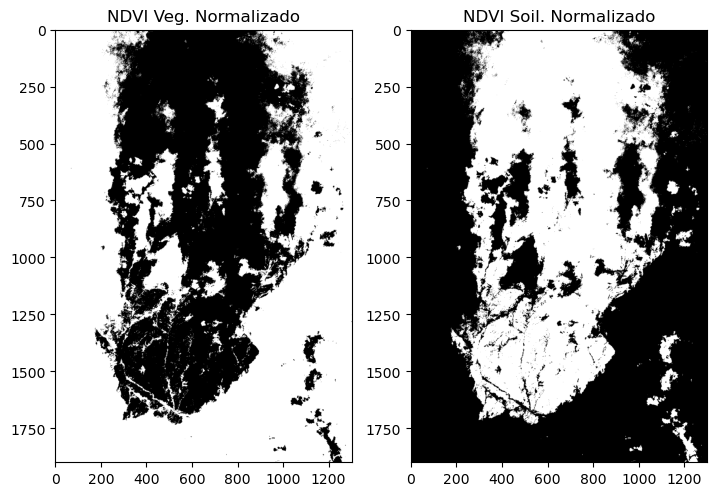

In [16]:
# Basándome en lo anterior, decido seguir al pie de la letra el paper.
# Los mejores resultados los obtengo solo usando el NVDI y NMDI DE VEGATCIÓN y aplicando el umbral que aparece adecuado. Por tanto:

# 1. Cálculo de NDVI
# bandas 3 y 4, que son la ROJA y NIR 
banda_roja = arizona_banda3
banda_nir = arizona_banda4
# Calcuamos NDVI 
banda_roja = banda_roja.astype(np.float32)
banda_nir = banda_nir.astype(np.float32)
ndvi = (banda_nir - banda_roja) / (banda_nir + banda_roja)
# También tenemos nans, los ponemos a un valor medio entre -1 y 1
ndvi = np.nan_to_num(ndvi, nan=-1)

# Aquí está la clave. Normalizar y calcular un percentil 
# para simular el mismo umbral que usa en el paper.

#Normalizo entre 0 y 1, el paper habla todo el rato entre 0 y 1. 
ndvi = cv2.normalize(ndvi, None, 0,1,cv2.NORM_MINMAX)
# Calculamos el percentil 40, para distinguir entre suelo y vegetación según propone el artículo.
# Como mejor se ve es con un percentil al 70%, que sí que distingue bien suelo de vegetación, pero sigamos las indicaciones del paper
percentil_40 = np.percentile(ndvi, 40)

ndvi_veg = np.where(ndvi >=percentil_40, 255, 0)
ndvi_soil = 255 - ndvi_veg
plt.figure(figsize=(13,6))
plt.subplot(131), plt.imshow(ndvi_veg,'gray'), plt.title("NDVI Veg. Normalizado")
plt.subplot(132), plt.imshow(ndvi_soil,'gray'), plt.title("NDVI Soil. Normalizado")

(<Axes: title={'center': 'NMDI Soil. Normalizado'}>,
 Text(0.5, 1.0, 'NMDI Soil. Normalizado'))

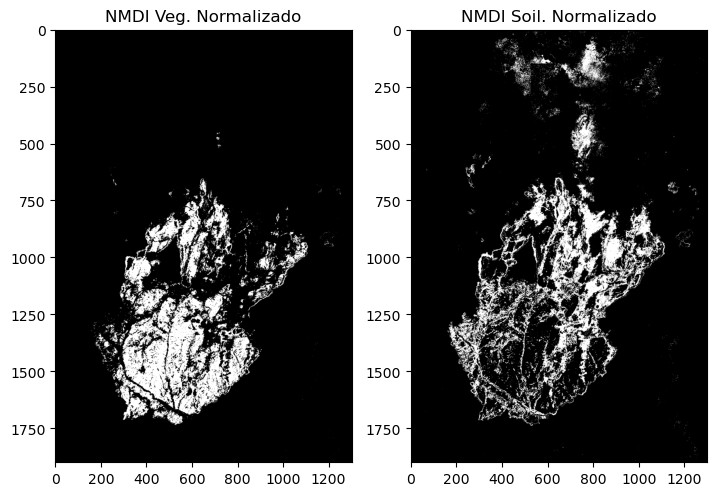

In [17]:
# 2. Cálculo del NMDI
banda_nir = arizona_banda4
banda_mnir = arizona_banda5
banda_mnir_2 = arizona_banda7
# Calcuamos NMDI 
banda_nir = banda_nir.astype(np.float32)
banda_mnir = banda_mnir.astype(np.float32)
banda_mnir_2 = banda_mnir_2.astype(np.float32)
nmdi = (banda_nir - (banda_mnir - banda_mnir_2)) / (banda_nir + (banda_mnir - banda_mnir_2))
# Tenemos valores infinitos y nans por la operación, regularizamos
nmdi = np.where(np.isinf(nmdi), 1, nmdi)
# También tenemos nans, los ponemos a un valor medio entre -1 y 1
nmdi = np.nan_to_num(nmdi, nan=-1)

#Normalizo entre 0 y 1, el paper habla todo el rato entre 0 y 1. 
nmdi = cv2.normalize(nmdi, None, 0,1,cv2.NORM_MINMAX)
nmdi_veg = nmdi 
# Calculamos el de suelo como 0.9 - nmdi
nmdi_soil = 0.9 - nmdi_veg

# Calculamos el percentil 10 (He probado con 20 y no sale tan bien), 
# para distinguir entre suelo y vegetación según propone el artículo.
# En el artículo habla de valores <= 2 (o percentil 20% para rango entre 0 y 1)
percentil_20_veg = np.percentile(nmdi_veg, 10)
percentil_20_soil = np.percentile(nmdi_soil, 10)


# 1.1. Separación entre píxeles de fuego y no fuego
nmdi_veg = np.where(nmdi_veg <=percentil_20_veg, 255, 0)
nmdi_soil = np.where(nmdi_soil <=percentil_20_soil, 255, 0)


plt.figure(figsize=(13,6))
plt.subplot(131), plt.imshow(nmdi_veg,'gray'), plt.title("NMDI Veg. Normalizado")
plt.subplot(132), plt.imshow(nmdi_soil,'gray'), plt.title("NMDI Soil. Normalizado")



(<Axes: title={'center': 'AND  de NDVI y MDVI vegetación (Algoritmo NMDI)'}>,
 Text(0.5, 1.0, 'AND  de NDVI y MDVI vegetación (Algoritmo NMDI)'))

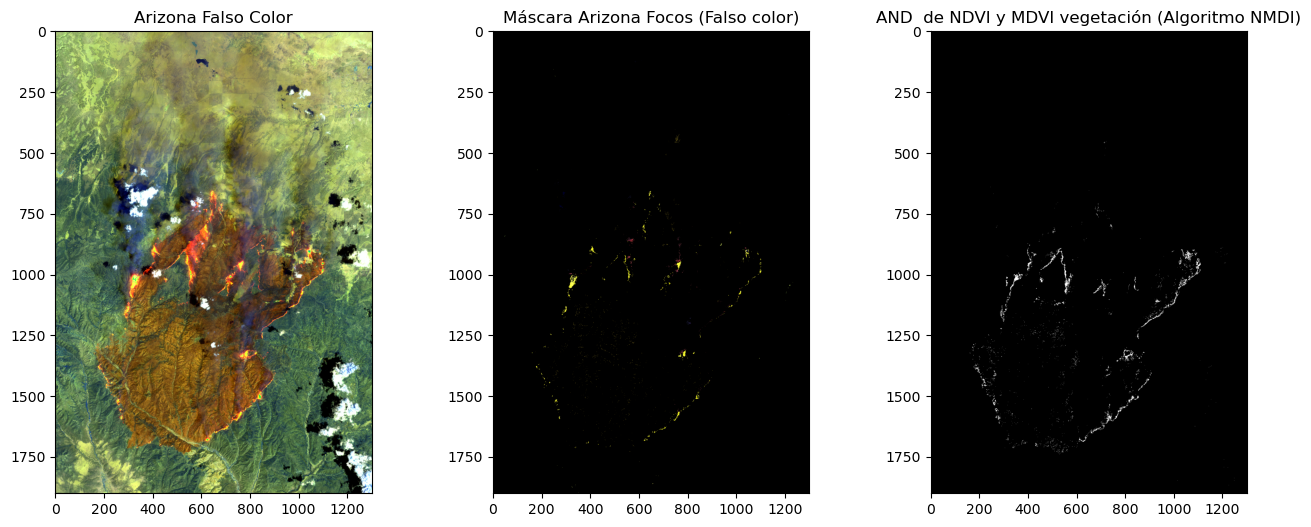

In [18]:
# Haciendo las siguientes operaciones, obtenemos algo que parece más acorde a lo que buscamos:
mask_1 = cv2.bitwise_and(ndvi_veg, nmdi_veg)
mask_2 = cv2.bitwise_and(ndvi_soil, nmdi_soil)

plt.figure(figsize=(16,6))
plt.subplot(131), plt.imshow(arizona_falso_color), plt.title("Arizona Falso Color")
plt.subplot(132), plt.imshow(cv2.cvtColor(res_focos,cv2.COLOR_BGR2RGB)), plt.title("Máscara Arizona Focos (Falso color)")
plt.subplot(133), plt.imshow(mask_1,'gray'), plt.title("AND  de NDVI y MDVI vegetación (Algoritmo NMDI)")

# Esto es lo más cercano que he conseguido para detectar los focos del incendio usando el algoritmo. 
# Al final, lo que mejor ha funcionado ha sido combinar las máscaras de ndvi y nmdi de vegetación. 

# En la tercera imagen se observan claramente la mayoría de focos del incendio calculados usando el algoritmo, prácticamente igual que teníamos en 
# el apartado anterior, usando la imagen en falso color. 

# Efectivamente, el algoritmo del paper es una buena forma de detección de focos de incendio.

# 3. ADRA

**En la imagen de Adra, haz uso de la banda pancromática (alta resolución) para producir una imagen en color (RGB) de alta resolución (el doble de resolución que las bandas visibles R, G, B). Puedes aplicar algún algoritmo que mejore el color del resultado para darle más viveza o colorido. Para obtener una imagen RGB de mayor resolución usando la imagen pancromática usar:**
1. **En la representacion HSV cambiar la luminancia por la imagen pancromatica**
2. **Usando la transformada wavelet de la imagen pancromatica como se sugiere en este artículo**
3. **Cualquier otro algoritmo propuesto por vosotros/as**

</br>

In [19]:
# Cargamos bandas
adra_banda1 = cv2.imread("LandSat/adra/banda1.tif",0)
adra_banda2 = cv2.imread("LandSat/adra/banda2.tif",0)
adra_banda3 = cv2.imread("LandSat/adra/banda3.tif",0)
adra_banda4 = cv2.imread("LandSat/adra/banda4.tif",0)
adra_banda5 = cv2.imread("LandSat/adra/banda5.tif",0)
adra_banda61 = cv2.imread("LandSat/adra/banda61.tif",0)
adra_banda62 = cv2.imread("LandSat/adra/banda62.tif",0)
adra_banda7 = cv2.imread("LandSat/adra/banda7.tif",0)
adra_banda8 = cv2.imread("LandSat/adra/banda8.tif",0)

adra_rgb = cv2.imread("LandSat/adra/rgb.jpg")

# Veamos la dimensión de las imágenes (todas las seleccionadas tienen la misma dimensión):
adra_banda8.shape

(512, 512)

(<Axes: >, <matplotlib.image.AxesImage at 0x7fe477383e50>)

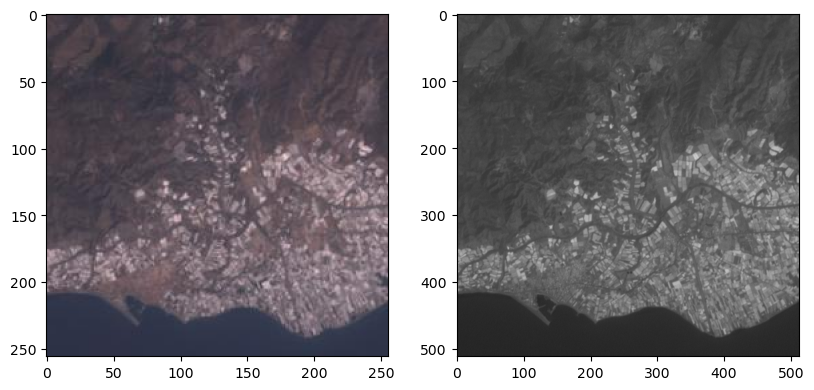

In [20]:
# Representación cargada de Adra RGB y banda Pancromática
plt.figure(figsize=(15,6))
plt.subplot(131), plt.imshow(cv2.cvtColor(adra_rgb, cv2.COLOR_BGR2RGB))
plt.subplot(132), plt.imshow(cv2.cvtColor(adra_banda8, cv2.COLOR_BGR2RGB))

# A simple vista, se ve que la pancromática tiene mejor resolución que la RGB que se nos aporta
# Podríamos haber calculado la RGB como hicimos en el ejercicio 1, pero ya nos la dan:
# img_rgb_adra = cv2.merge([adra_banda1, adra_banda2, adra_banda3])

##### **ALTERNATIVA 1: En la representacion HSV cambiar la luminancia por la imagen pancromatica**

(<Axes: title={'center': 'Adra Mejorada'}>,
 Text(0.5, 1.0, 'Adra Mejorada'))

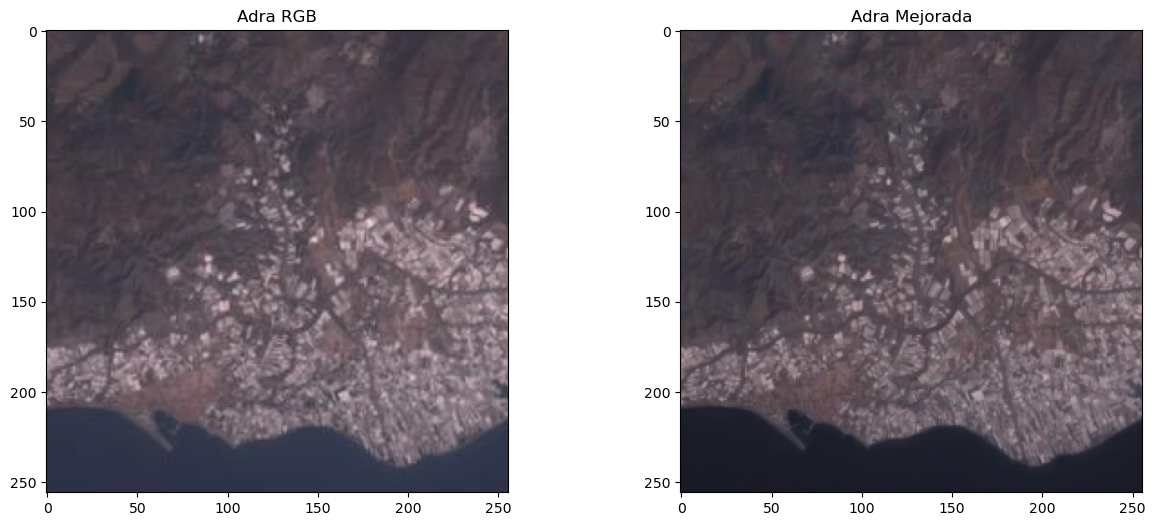

In [21]:
# Pasar a HSV la rgb que tenemos
adra_hsv = cv2.cvtColor(adra_rgb, cv2.COLOR_BGR2HSV)
# Dado que la pancromática está al doble de resolución, cambiamos su size
pancromatica = cv2.resize(adra_banda8, (adra_banda1.shape[1], adra_banda1.shape[0]))
# Sustituir la luminancia por la banda 8, que es la Pancromática
adra_hsv[:, :, 2] = pancromatica
# Pasar de nuevo a RGB y visualizar
adra_better = cv2.cvtColor(adra_hsv, cv2.COLOR_HSV2RGB)

plt.figure(figsize=(15,6))
plt.subplot(121), plt.imshow(cv2.cvtColor(adra_rgb,cv2.COLOR_BGR2RGB)), plt.title("Adra RGB")
plt.subplot(122), plt.imshow(adra_better), plt.title("Adra Mejorada")

# Sí que se aprecia mayor resolución. Fijarse en el cabo de abajo y líneas de carretera

##### **ALTERNATIVA 2: Usando la transformada wavelet de la imagen pancromatica como se sugiere en este [artículo](https://pradoposgrado2324.ugr.es/pluginfile.php/157629/mod_assign/intro/Wavelet-based_image_fusion_of_Landsat_ETM_images_a.pdf)**

El paper indicado provee el siguiente algoritmo para fusionar en una Wavelet. 

<img src="doc/alg_articulo2.png">

Además, indica que ha usado transformaciones biortogonales, por lo que usaremos bior3.7

(<Axes: >, <matplotlib.image.AxesImage at 0x7fe474fe1150>)

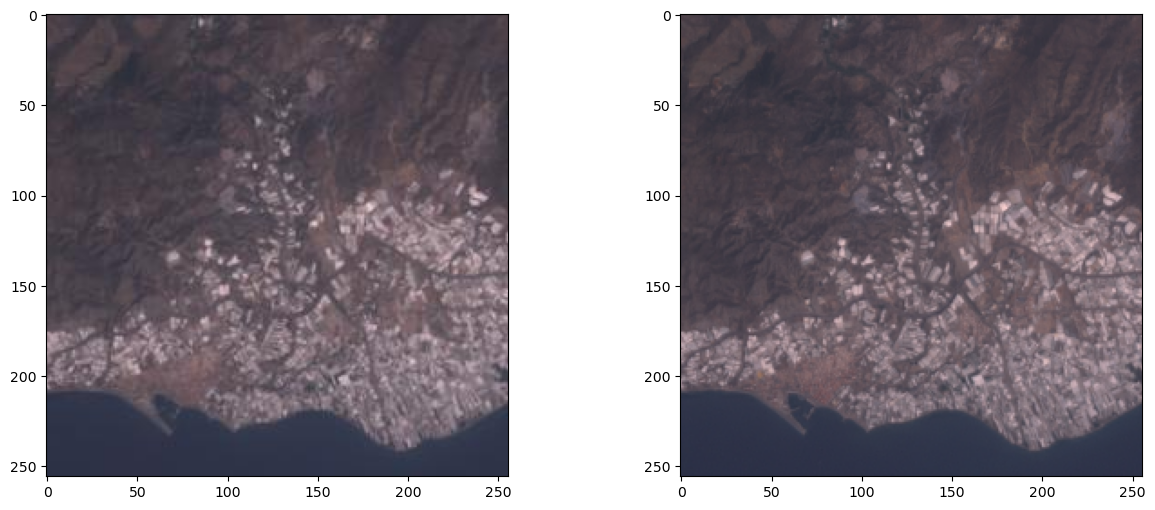

In [22]:
# Ponemos las bandas en nombre que sea facil identificar
banda1 = adra_banda1
banda2 = adra_banda2
banda3 = adra_banda3
# Resize de la banda pancromática para que sea igual que las otras
pancromatica = cv2.resize(adra_banda8,(adra_banda1.shape[1], adra_banda1.shape[0]))

bandas_rec = []
# Iteramos para cada banda R,G,B
for band in [banda1, banda2, banda3]:

    # Obtenemos wavelet de la banda pancromática
    coeffs = pywt.dwt2(pancromatica, 'bior3.7')
    (LL, (HL, LH, HH)) = coeffs

    # Obtenemos coeficientes de la banda a analizar
    coeffs_band = pywt.dwt2(band, 'bior3.7')
    (LL_band, (HL_band, LH_band, HH_band)) = coeffs_band

    # Sustituimos el coeficiente de aproximación de la pancromática
    # por el coeficiente de aproximación de la banda bajo estudio
    LL_a_reemplazar = LL_band

    # Reconstruimos
    rec = pywt.idwt2((LL_a_reemplazar, (HL, LH, HH)), 'bior3.7')
    rec = rec.astype('uint8')
    # Añadimos al array de bandas procesadas
    bandas_rec.append(rec)

# Con las bandas reconstruidas, mergeamos
rec_def = cv2.merge([bandas_rec[0],bandas_rec[1],bandas_rec[2]])

# Mostramos
plt.figure(figsize=(15, 6))
plt.subplot(121),plt.imshow(cv2.cvtColor(adra_rgb, cv2.COLOR_BGR2RGB))
plt.subplot(122),plt.imshow(cv2.cvtColor(rec_def, cv2.COLOR_BGR2RGB))

# Se ve bastante mejor, sobre todo de nuevo en zona de carreteras y zona de la bahía

# 4. BIBLIOGRAFÍA

- Detalle de LandSat: https://pradoposgrado2324.ugr.es/pluginfile.php/157629/mod_assign/intro/techguide_landsat-1.pdf
- Algoritmo NMDI: https://pradoposgrado2324.ugr.es/pluginfile.php/157629/mod_assign/intro/WangQuHao-1.pdf
- Fusión de imagenes Wavelet: https://pradoposgrado2324.ugr.es/pluginfile.php/157629/mod_assign/intro/Wavelet-based_image_fusion_of_Landsat_ETM_images_a.pdf
- Apuntes y transparencia de clase (Visión por computador - Master DATCOM - UGR)